# Code Assignment Mod6L14 — Confusion Matrix & Metrics on Restaurant Inspections

**Format:** Instructor Guidance → Your Task → We Share (Reflection)

**Goal:** Using the same **classification workflow** and models as last time, build confusion matrices and calculate accuracy, precision, and recall of each model.  


## Instructor Guidance (Pseudocode + Docs)

Use this as a roadmap; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- Confusion Matrix / Classification Report — scikit-learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics  
- `pandas.get_dummies` (one-hot) — https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Guidance (same models as last challenge -- FEEL free to copy and paste the code that you need from the last code assignment)

1) **Load CSV** → preview shape & columns.  
2) **Define target (y)** as a **binary** label: e.g., `CRITICAL FLAG == "Critical"` → 1, else 0 *(positive class = “Critical”)*.  
3) **Pick features (X)**: start small (`SCORE`), then add categorical dummies (`BORO`, `CUISINE DESCRIPTION`), keep it simple.  
4) **Minimal prep**: coerce **only used columns** to numeric (for numeric features); `get_dummies` for categoricals (`drop_first=True`). Drop NA rows on used cols.  
5) **Train–test split (80/20)** with fixed `random_state`.  
6) **Fit the same model** as last time (e.g., `LogisticRegression`), predict on **test**.  
7) **Evaluate**: confusion matrix, **accuracy**, **precision**, **recall**, **F1** (classification_report).  
8) **Repeat for 2 more models** (A (baseline)/B (single term)/C (more than one term)) on the **same split**; compare metrics.  
9) **Decide** which model is better for the business goal based on **precision vs recall** trade-offs.  


## Your Task

Work in pairs. Comment your choices briefly. Keep code simple and readable.

> **Reminder (last challenge model):** You trained **LogisticRegression**, on three models you will use those same 3 models!


In [49]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### 1) Read the Restaurant Inspection CSV & Preview

In [50]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251110.csv'
df = pd.read_csv(path)

In [51]:
# cleaning our data
df_cleaned = df.dropna(subset=['SCORE', 'CRITICAL FLAG', 'BORO', 'CUISINE DESCRIPTION'])
df_cleaned = df[['SCORE', 'CRITICAL FLAG', 'BORO', 'CUISINE DESCRIPTION']]

df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].astype(str)
df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].str.strip().str.lower()

crit_num = []
for x in df_cleaned['CRITICAL FLAG']:
    if x == "critical":
        crit_num.append(1)
    elif x == "not applicable":
        crit_num.append(2)
    else:
        crit_num.append(0)
    
df_cleaned['CRITICAL_NUM'] = crit_num


/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_34698/3848946594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].astype(str)
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_34698/3848946594.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['CRITICAL FLAG'] = df_cleaned['CRITICAL FLAG'].str.strip().str.lower()
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_34698/3848946594.py:17: SettingWithCopyWarnin

In [52]:
display(df_cleaned['CUISINE DESCRIPTION'].value_counts(ascending=True).reset_index())

,CUISINE DESCRIPTION,count
0,Chimichurri,2
1,Haute Cuisine,5
2,Polynesian,6
3,Czech,15
4,Nuts/Confectionary,35
...,...,...
85,Latin American,13341
86,Pizza,17372
87,Coffee/Tea,20230
88,Chinese,28426


In [53]:
# for CUISINE DESCRIPTION categories, I will take top 5 most frequent and make all others "other"

# top 5 + bottom rest
top5_cuisines = df_cleaned['CUISINE DESCRIPTION'].value_counts(ascending=False).head().index.tolist()
the_rest = ~(df_cleaned['CUISINE DESCRIPTION'].isin(top5_cuisines))

# Replacing with Other if not in top5_cuisines
df_cleaned['CUISINE DESCRIPTION'].loc[the_rest] = 'Other'
df_cleaned['CUISINE DESCRIPTION'].value_counts()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_34698/3744077744.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cleaned['CUISINE DESCRIPTION'].loc[the_rest] = 'Other'
/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipyker

CUISINE DESCRIPTION
Other             166945
American           45391
Chinese            28426
Coffee/Tea         20230
Pizza              17372
Latin American     13341
Name: count, dtype: int64

In [54]:
df_cleaned = df_cleaned.dropna()
df_cleaned

,SCORE,CRITICAL FLAG,BORO,CUISINE DESCRIPTION,CRITICAL_NUM
12,7.0000,critical,Manhattan,Other,1
19,10.0000,not critical,Manhattan,Other,0
22,12.0000,critical,Manhattan,Other,1
33,0.0000,not applicable,Bronx,Other,2
38,9.0000,critical,Brooklyn,Other,1
...,...,...,...,...,...
291700,26.0000,not critical,Manhattan,Other,0
291701,13.0000,critical,Manhattan,Other,1
291702,29.0000,not critical,Queens,Latin American,0
291703,9.0000,critical,Brooklyn,Other,1


### 2) Define the Binary Target (y)

We’ll predict whether an inspection had a **Critical violation**.

- Target rule: `CRITICAL FLAG == "Critical"` → **1**, else **0**.
- Positive class = **1 (Critical)** — keep this in mind for **precision/recall** meaning.


In [55]:
y = df_cleaned['CRITICAL_NUM']

X1 = sm.add_constant(df_cleaned[['SCORE']])
X2 = sm.add_constant(df_cleaned[['SCORE', 'BORO']])
X3 = sm.add_constant(df_cleaned[['SCORE', 'BORO', 'CUISINE DESCRIPTION']])

### 3) Create Three Models (you can copy and paste the same modeling code from last code assignment here it is okay if your models have different features as long as you have 3 models)

- **Model A (minimal numeric):** `SCORE` only (lower is better in NYC scoring).  
- **Model B (add location):** `SCORE` + one-hot `BORO`.  
- **Model C (richer categories):** `SCORE` + one-hot `BORO` + top cuisines (one-hot of `CUISINE DESCRIPTION` limited to most frequent K).

> If any column is missing in your file, skip that spec or adjust accordingly.


In [56]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y, train_size=0.7, test_size=0.3, stratify=y, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(X2, y, train_size=0.7, test_size=0.3, stratify=y, random_state=42)
x3_train, x3_test, y3_train, y3_test = train_test_split(X3, y, train_size=0.7, test_size=0.3, stratify=y, random_state=42)

In [66]:
# Pipe 1

scaler = StandardScaler()
x1_train_scaled = scaler.fit_transform(x1_train)
x1_test_scaled = scaler.transform(x1_test)


In [57]:
# Pipeline 2

num_features2 = ['SCORE']
cat_features2 = ['BORO']

num_pipe2 = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe2 = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pre2 = ColumnTransformer(
    transformers= [
        ('num', num_pipe2, num_features2),
        ('cat', cat_pipe2, cat_features2)
    ])

pipe2 = Pipeline([
    ('pre', pre2),
    ('model', LogisticRegression())
])

In [58]:
# Pipeline 3

num_features3 = ['SCORE']
cat_features3 = ['BORO', 'CUISINE DESCRIPTION']

num_pipe3 = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe3 = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

pre3 = ColumnTransformer(
    transformers= [
        ('num', num_pipe3, num_features3),
        ('cat', cat_pipe3, cat_features3)
    ])

pipe3 = Pipeline([
    ('pre', pre3),
    ('model', LogisticRegression())
])

### 4) Minimal Cleaning: Drop NAs in Used Columns

Do this **per model** so each spec uses its own “clean” subset (same **target** slice).


In [59]:
# Already did before

### 5) Train–Test Split (same split for all models)

Use **the same random_state** so models A/B/C are comparable.


In [60]:
# Train split before

### 6) Fit the Same Models on the Train sets (Logistic Regression), Get Predictions, Print Confusion Matrices & Metric Reports

> **This is new**:  Be sure to look up documentation on `confusion_matrix` and `classification_report`.  Get a matrix and metrics report (accuracy, precision, recall, f1) for each model.


In [69]:
# model 1 preds

logreg = LogisticRegression()
model1 = logreg.fit(x1_train, y1_train)
y1_pred = model1.predict(x1_test)

In [61]:
# model 2 preds
model2 = pipe2.fit(x2_train, y2_train)
y2_pred = model2.predict(x2_test)

In [62]:
# model 3 preds
model3 = pipe3.fit(x3_train, y3_train)
y3_pred = model3.predict(x3_test)

/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 7) Visualize One Confusion Matrix 

Be able to interpret this Matrix 

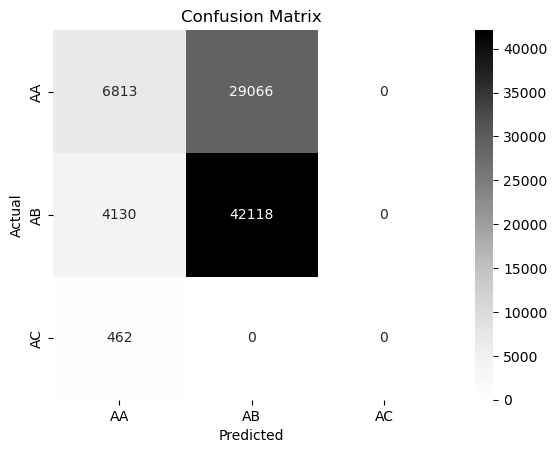

              precision    recall  f1-score   support

          AA       0.60      0.19      0.29     35879
          AB       0.59      0.91      0.72     46248
          AC       0.00      0.00      0.00       462

    accuracy                           0.59     82589
   macro avg       0.40      0.37      0.34     82589
weighted avg       0.59      0.59      0.53     82589



/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/data-analysis-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [63]:
# confusion matrix 2
cm2 = confusion_matrix(y2_test, y2_pred)

# visualizing with heatmap
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greys',
            xticklabels=['AA', 'AB', 'AC'],
            yticklabels=['AA', 'AB', 'AC'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# report
print(classification_report(y2_test, y2_pred, target_names=['AA', 'AB', 'AC']))

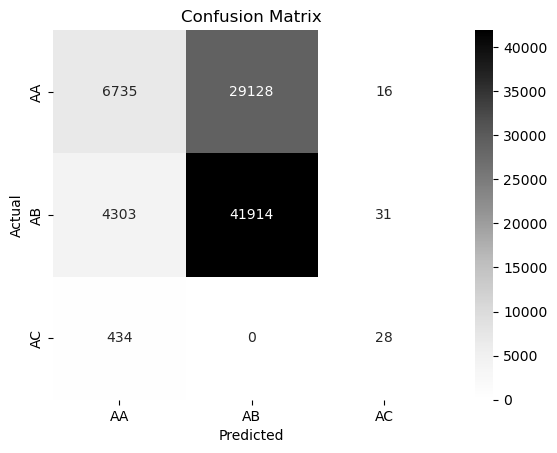

              precision    recall  f1-score   support

          AA       0.59      0.19      0.28     35879
          AB       0.59      0.91      0.71     46248
          AC       0.37      0.06      0.10       462

    accuracy                           0.59     82589
   macro avg       0.52      0.38      0.37     82589
weighted avg       0.59      0.59      0.52     82589



In [64]:
# confusion matrix 3
cm3 = confusion_matrix(y3_test, y3_pred)

# visualizing with heatmap
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greys',
            xticklabels=['AA', 'AB', 'AC'],
            yticklabels=['AA', 'AB', 'AC'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# report
print(classification_report(y3_test, y3_pred, target_names=['AA', 'AB', 'AC']))



### 8) Decide Which Model Is “Better” — Explain Your Metric Choice

- If the **cost of missing a Critical** violation is high → prioritize **Recall** on the positive class.  
- If the **cost of wrongly flagging Critical** is high → prioritize **Precision** on the positive class.  
- If you want a balance → **F1**.

Write 3–5 sentences justifying your pick using the table above (Precision/Recall/F1).


## We Share (Reflection)

1) **Chosen model (A/B/C)** and **why**, referencing **Precision/Recall/F1** for the **Critical (1)** class.  
2) Your **confusion matrix** and a one-liner in plain English:  
   - “Out of all inspections we predicted **Critical**, **X%** were actually Critical (Precision).  
   - Of all actually **Critical** inspections, we caught **Y%** (Recall).”  

I believe Model 2 (B) is the best choice. Given our f1-score, Model B performed better (albeit only slightly), with our precision indicating that of all inspections we predicted critical, about 60% of them were actually critical. Furthermore, of all real critical inspections, we caught 91% of them. Although model B and C were very similar, model B performed slightly better, leading to Model B being my choice.

***

## Code-Along for Reference

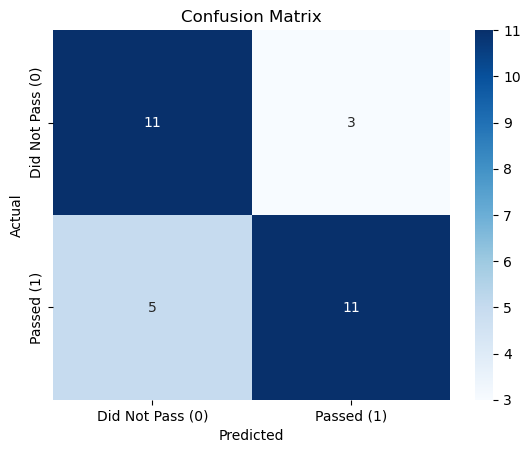


--- Classification Report ---
                  precision    recall  f1-score   support

Did Not Pass (0)       0.69      0.79      0.73        14
      Passed (1)       0.79      0.69      0.73        16

        accuracy                           0.73        30
       macro avg       0.74      0.74      0.73        30
    weighted avg       0.74      0.73      0.73        30



In [65]:
# --- First, we must recreate the model and predictions from Reading 13 ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

np.random.seed(1)
hours_studied = np.random.randn(100, 1) * 2 + 5
prob_passing = 1 / (1 + np.exp(-(hours_studied * 1.5 - 7.5)))
passed = np.random.binomial(1, prob_passing.flatten(), 100)
df_class = pd.DataFrame({'hours_studied': hours_studied.flatten(), 'passed': passed})

X = df_class[['hours_studied']]
y = df_class['passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
# --- End of setup ---


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Pass (0)', 'Passed (1)'],
            yticklabels=['Did Not Pass (0)', 'Passed (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 3. Generate the full classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Did Not Pass (0)', 'Passed (1)']))